# STRUCTURE 
#### 1. Introduction & Approach
#### 2. Data Extraction
#### 3. Data Exploration
#### 4. Research 
#### 5. Sentiment 
#### 6. Evaluation 
#### 7. Conclusions



# Introduction & Approach

The "short-squeeze": a compelling episode that took place in early 2021 involving the Reddit's subreddit r/wallstreetbets, powerful hedge funds, and previously declining stocks, amongst which special attention was given to the video game retailer Game Stop (GME). What happened exactly? In short (pardon the pun), retail investors got organised on r/wallstreetbets to mass-purchase GME and other stocks, which funds like Melvin Capital had heavily shorted. This led to an increase in share price, causing lossess to the hedge funds, which in turn bought more shares to compensate for losses, hence driving the share price up even more, from X EUR in December, skyrocketed to Y EUR in late January. 

We are interested in identifying this phenomenon by looking at the sentiment of submissions (or posts) on r/wallstreetbets concerning the stock GME, and in asserting the extent of its relationship with the share price. Theoretically, the stock price is actually a represesntation of sentiment about a specific asset or company: if many people appreciate your products or believe in your vision, i.e. have positive sentiment about your company, they are likely to buy and hold your stock hence increasing its price. Analysing the submissions on the subreddit is another way of obtaining such sentiment. Therefore, our expectations are that the sentiment of the posts and the price should follow similar trends. Given that its such a concise phenomenon and the interaction of various parties (investors, trading platforms, stock exchanges, news outlets...) we are also interested in looking at how exogenous events influenced the stock price.

Hence our research questions are:  
1. *How does the sentiment trend on r/wallstreetbets compare to GME's stock price?* 
2. *How were the sentiment and the stock price influenced by major exogenous events?*

Our approach consists in four main phases: Data Extraction, Data Exploration, Research, and Sentiment Analysis. We begin by obtianing the data necessary for the analysis from the relevant APIs; then we explore the data: we look at the daily frequency of submissions, most used words, emojis and specific r/wallstreetbets "lingo". Further, we look into the event itself gather information to answer out second research question. Then we proceed with analysing the sentiment using three main approaches on a varying spectrum of model customisability, from the most off-the-shelf with textBlob, to a Vader model updatd with specific "lingo", to a custom \bf{HUBER} classifier trained with word embedding techniques. Finally, we gather our findings, evaluate them and conclude. 

# Data Extraction 

In [1]:
# We use the following library to import data:
# https://towardsdatascience.com/free-stock-data-for-python-using-yahoo-finance-api-9dafd96cad2e
import yfinance as yf

name = "GME"
start = "2020-03-20"
end = "2020-05-20"
interval = "1h"

# get info stock:
def get_stockdata(name, start, end, interval):
    GME = yf.Ticker(name)
    stock_data = GME.history(start=start, end=end, interval=interval, prepost= True)
    stock_data.reset_index(inplace=True)
    return stock_data

In [ ]:
from psaw import PushshiftAPI
import datetime as dt
import logging as log
import csv
import pandas as pd
import os 


# -- -- -- Methods for fetching Data from Pushshift API -- -- -- #

api = PushshiftAPI()
start_time = dt.datetime(2020, 12, 20) 
end_time = dt.datetime(2021,  2, 19)

# .TXT
# Accesses Pushshift API
# splits the time frame (%start_time and %end_time) in blocks of %time_delta days 
# Creates a separate .txt file for each block
# Each .txt files contains the Reddit submissions containing the word "GME" in the title
def throttle_requests_totxt(start_time, end_time, time_delta):
    tmp_etime = start_time + time_delta

    while tmp_etime < end_time:
        submissions = api.search_submissions(
                            after=int(start_time.timestamp()),
                            before=int(tmp_etime.timestamp()),
                            subreddit='wallstreetbets',
                            filter=['url', 'author', 'title',
                                'subreddit', 'created_utc'],
                            # limit= 100
                            )
        with open(f'wsb_{start_time}_{tmp_etime}.txt', 'w') as f:
            for sub in submissions:
                wrds = sub.title.split()
                if "GME" not in wrds: continue
                else:
                    log.warning(f"Sub title: {sub.title}")
                    f.write(f"{sub}\n")
            f.flush()

        start_time = tmp_etime
        tmp_etime = start_time + time_delta
    return "Done"

# # Uncomment Here below to download all .TXT files for the time period specifcied above
# x = throttle_requests_totxt(start_time, end_time, dt.timedelta(10)) #10 day cycle
# print(x)


# CSV 
# Accesses Pushshift API
# splits the time frame (%start_time and %end_time) in blocks of %time_delta days 
# Creates a separate .csv file for each block
# Each .csv files contains the Reddit submissions containing the word "GME" in the title
def throttle_requests_tocsv(start_time, end_time, time_delta):
    tmp_etime = start_time + time_delta

    while tmp_etime < end_time:
        submissions = api.search_submissions(
                            after=int(start_time.timestamp()),
                            before=int(tmp_etime.timestamp()),
                            subreddit='wallstreetbets',
                            filter=['url', 'author', 'title',
                                'subreddit', 'created_utc', 'id', 'score', 'upvote_ratio'],
                            # limit= 100
                            )

        with open(f'wsb_{start_time}_{tmp_etime}.csv', 'w') as f: 
            sub_writer = csv.writer(f, delimiter=',', quotechar='"', quoting=csv.QUOTE_NONNUMERIC)
            sub_writer.writerow(['id', 'created_utc', 'author', 'title', 'url', 'score', 'upvote_ratio'])

            for sub in submissions: 
                wrds = sub.title.split()
                if "GME" not in wrds: continue 
                else: 
                    log.warning(f"Sub ID:{sub.id}, Sub created_utc: {sub.created_utc}, Sub title: {sub.title[:10]}, Sub score:{sub.score}")
                    sub_writer.writerow([sub.id, sub.created_utc, sub.author, sub.title, sub.url, sub.score, sub.upvote_ratio])           

        start_time = tmp_etime
        tmp_etime = start_time + time_delta
    return "Done"

# # Uncomment Here below to download all CSV files for the time period specifcied above
# x = throttle_requests_tocsv(start_time, end_time, dt.timedelta(10)) #10 day cycle
# print(x)
        
# -- -- -- -- Parsing from CSV to pandas.DataFrame -- -- -- -- #
df_dict = {}
for filename in os.listdir("./files"):
    df_dict[filename] = pd.read_csv(f"./files/{filename}")

sub_df = pd.concat([df for df in df_dict.values()]).reset_index(drop=True)

# convert utc to normal date
sub_df["created_utc"] = sub_df["created_utc"].apply(lambda x: dt.datetime.fromtimestamp(int(x)).strftime("%Y-%m-%d %H:%M:%S"))
sub_df.rename(columns={'created_utc':'created'}, inplace=True)

#sub_df.to_csv("sub_df_new.csv")
#print(sub_df.head())
#print(sub_df.tail())

# Data Exploration

- Plots of number of submissions with open and close prices. 
- Preprocessing of words 
- Word Frequnecy
- Analysis and WordClouds
- WSB Lingo 
- Emoji Analysis 
- Conclusions, challenges and potentail solutions (being aware and critical of our own approach). 

# Research

- Timeline of Events, make viausally appealing, maybe use a nice design or a cool slide template 
- Plot the same timeline on the stock price chart
- Diuscuss on the posssble implications

# Sentiment

- Introduction on types of sentiment analysis and off-the shelft solutions + advantages + shortcomngs
- Introduction on more elaborate sentiment methods, advatages + shortcomings 
- Preprocessing - done
- TextBlob - done
- Vader - done
- WordVectors + SVC 
- RNN ?
- Results 

There are many tools available for semtiment analysis. On a spectrum between off-the-shelf and custom, off-the-shelf tools are fast, easy and accessible libraries of pre-trained models that semalessly provide a measure of polarity (positive or negative sentiment) on a given text input. On the other hand, custom models are possbly more accurate and a better fit to the specific problem you're trying to solve, but they take more time and require a deeper understanding of the underlying techniques. Finally, there are also many solutions in between: off-the-shelf that offer some customisation, advanced techniques that can be applied quickly. We begin by looking at TexBlob, the easiest and quickest, then we move to Vader, which offers some customisation, and the we explore other sentiment techniques using wor embeddings. 

Before applying any technique, we preprocess our dataset in order to strip it from characters and unuseful text. We lowercase all the text in submissions, remove stop words, and lemmatize the text.

### Importing Data

In [1]:
import pandas as pd
sub_df = pd.read_csv("sub_df.csv")
sent_df = sub_df.loc[:,("created", "author", "title")]
sent_df.loc[:,"created"] = pd.to_datetime(sub_df.loc[:,'created']).dt.floor('d') 
sent_df.head()

,created,author,title
0,2020-12-29,WallStWarlock,GME sign from the QUAZAR.
1,2020-12-29,Cali_Godbod,5th trade: GME Gang rise up
2,2020-12-29,Blitz100000,How much to invest in GME and PLTR
3,2020-12-29,kunjinn,"Yesterday I was celebrating, today I am in the..."
4,2020-12-29,Effect_Wild,"GME DD, look at all the out of stock stickers ..."


In [2]:
stock_df = pd.read_csv("gme_stock_data.csv")
stock_df = stock_df.loc[:, ~stock_df.columns.str.contains('^Unnamed')]
stock_df.head()

,Date,Open,High,Low,Close,Volume,Dividends,Stock Splits
0,2020-12-21,15.810000,16.350000,15.280000,15.530000,9876100,0,0
1,2020-12-22,16.219999,20.040001,16.150000,19.459999,30652700,0,0
2,2020-12-23,20.170000,22.350000,19.129999,20.570000,25830300,0,0
3,2020-12-24,21.010000,21.480000,19.950001,20.150000,6262200,0,0
4,2020-12-28,21.309999,21.969999,20.350000,20.990000,8965900,0,0


### Preprocessing 

In [ ]:
# because the nltk download script in the next cell is broken, 
# run this script and double-click on "all packages" to download the necssary data from nltk. 
# you can do this once only, so you can ignore this cell if you re-run this notebook. 
import nltk
import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:
    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context

nltk.download()

In [ ]:
#imports necessary, ignore if you ever run it previously
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')

In [3]:
import nltk
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import wordnet

#stopwords
from nltk.corpus import stopwords
stop = stopwords.words('english')

#part-of-speech tagging
def get_wordnet_pos(text):
  for tok, pos in nltk.pos_tag(word_tokenize(text)):
    if pos[0].lower() =='j':
      return wordnet.ADJ
    elif pos[0].lower() =='v':
      return wordnet.VERB
    elif pos[0].lower() =='n':
      return wordnet.NOUN
    elif pos[0].lower() =='r':
      return wordnet.ADV
    else:
      return wordnet.NOUN   #if anything else, just leave as noun

#lemmatization
lemmatizer = WordNetLemmatizer() 

def tagandlemma(title): 
  words = word_tokenize(title)
  lemmatized_words = [lemmatizer.lemmatize(word, pos=f"{get_wordnet_pos(word)}") for word in words]
  return " ".join(lemmatized_words)

Here we below apply the preprocessing functions, since our dataset contains around 76K submissions, it might take a while to run, so be patient :) or upload the already preprocessed csv in the subsequent cell. 

In [ ]:
import re
sent_df.loc[:,"ptitle"] = sent_df.loc[:,"title"].str.lower().str.replace(r'([^a-zA-Z\s])|(^https?:\/\/.*[\r\n]*)', ' ')
sent_df.loc[:,"ptitle"] = sent_df.loc[:,"ptitle"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
sent_df.loc[:,"ptitle"] = sent_df.loc[:,"ptitle"].apply(lambda x: tagandlemma(x))

In [4]:
#upload already preprocessed csv titles
sent_df.loc[:,"ptitle"] = pd.read_csv("preproc_titles.csv").loc[:,"title"]

In [5]:
sent_df.head()

,created,author,title,ptitle
0,2020-12-29,WallStWarlock,GME sign from the QUAZAR.,gme sign quazar
1,2020-12-29,Cali_Godbod,5th trade: GME Gang rise up,th trade gme gang rise
2,2020-12-29,Blitz100000,How much to invest in GME and PLTR,much invest gme pltr
3,2020-12-29,kunjinn,"Yesterday I was celebrating, today I am in the...",yesterday celebrate today gutter margin use gm...
4,2020-12-29,Effect_Wild,"GME DD, look at all the out of stock stickers ...",gme dd look stock sticker


### TextBlob

We apply textBlob sentiment on the processed title column "ptitle", which returns a number between -1 for negative, and 1 for porisitve polarity.

In [6]:
from textblob import TextBlob, Word

#apply textBlob sentiment 
sent_df.loc[:,"polarity_textBlob"] = sent_df.loc[:,"ptitle"].apply(lambda x: TextBlob(x).sentiment.polarity)

In order to plot the by sentiment by day, we create a new dataframe with two columns: "created" which hold the dates, and "polarity_textBlob" that takes the mean of the sentiment on that day. We also scale the sentiment values by dividing by the standard deviation in order to plot them together the stock price data. There are NaNs for stock price data on the days where the stock market is closed, so it's normal. 

In [7]:
#organise sentiment by date and standarside
daily_sent_df = sent_df.loc[:,("created", "polarity_textBlob")].groupby(["created"], as_index=False).mean()
daily_sent_df.loc[:,"z_polarity_textBlob"] = daily_sent_df.loc[:,"polarity_textBlob"]/daily_sent_df.loc[:,"polarity_textBlob"].std(axis=0)
daily_sent_df.loc[:,"created"] = pd.to_datetime(daily_sent_df.loc[:,"created"])

#standardize stock data as well
stock_df.loc[:,"z_open"] = stock_df.loc[:,"Open"]/stock_df.std(axis=0).iloc[1]
stock_df.loc[:,"z_close"] = stock_df.loc[:,"Close"]/stock_df.std(axis=0).iloc[1]
stock_df.loc[:,"Date"] = pd.to_datetime(stock_df.loc[:,"Date"])

# merge for plotting
merged = daily_sent_df.merge(stock_df.rename(columns={'Date': 'created'}).loc[:,["created","z_open","z_close"]], how='outer')
merged.head()

,created,polarity_textBlob,z_polarity_textBlob,z_open,z_close
0,2020-12-20,-0.008333,-0.335906,NaN,NaN
1,2020-12-21,-0.007686,-0.309826,0.138649,0.136194
2,2020-12-22,0.068960,2.779696,0.142245,0.170659
3,2020-12-23,-0.019292,-0.777630,0.176885,0.180393
4,2020-12-24,-0.055887,-2.252744,0.184252,0.176710


<AxesSubplot:xlabel='created', ylabel='vals'>

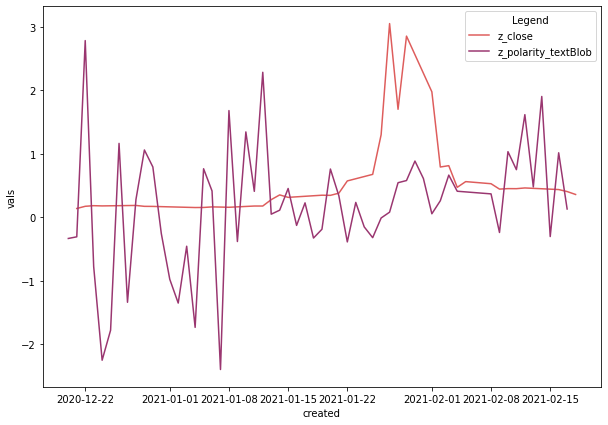

In [8]:
# Plotting 
import seaborn as sns
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,7))
mS = merged.loc[:,["created","z_close","z_polarity_textBlob"]].melt('created', var_name='Legend',  value_name='vals')
sns.lineplot(ax=ax, data=mS, x="created", y="vals", hue='Legend', palette="flare")

### Vader 

Because textBlob uses a "Bag-of-Words" approach based on a standard vocabulary, it performs relatively poorly. Vader is similar to textBlob, but it allows us to modify the vocabulary to include the specific lexicon used in our /wallstreetbets subreddit. So we use the data exploration analysis done previously to find the 100 most used words in the subreddit, and add them to our Vader Sentiment lexicon, and then we extract a new (hopefully improved) sentiment. 

We saved the most used word in the file "lexicon.py" as a dictionary, where to each word we manually assign a sentiment.

In [ ]:
#import file from directory
#import sys  
#sys.path.insert(0, '/Users/FCRA/Desktop/ALL/BSI/bsi-reddit-gme/pyfiles')

In [9]:
from lexicon import new_words_updated
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

vader = SentimentIntensityAnalyzer()

#update the lexicon with the new words
vader.lexicon.update(new_words_updated)

#apply Vader sentiment 
sent_df.loc[:,"polarity_vader"] = sent_df.loc[:,"ptitle"].apply(lambda x: vader.polarity_scores(x)["compound"])

In [10]:
sent_df.head()

,created,author,title,ptitle,polarity_textBlob,polarity_vader
0,2020-12-29,WallStWarlock,GME sign from the QUAZAR.,gme sign quazar,0.0,0.0000
1,2020-12-29,Cali_Godbod,5th trade: GME Gang rise up,th trade gme gang rise,0.0,0.0000
2,2020-12-29,Blitz100000,How much to invest in GME and PLTR,much invest gme pltr,0.2,0.0000
3,2020-12-29,kunjinn,"Yesterday I was celebrating, today I am in the...",yesterday celebrate today gutter margin use gm...,0.0,0.5719
4,2020-12-29,Effect_Wild,"GME DD, look at all the out of stock stickers ...",gme dd look stock sticker,0.0,0.0000


Similarly to before, we create a dataframe of sentiment by day. 

In [10]:
#organise sentiment by date and standarside
daily_sent_df_vader = sent_df.loc[:,["created", "polarity_vader"]].groupby(["created"], as_index=False).mean()
daily_sent_df_vader.loc[:,"z_polarity_vader"] = daily_sent_df_vader.loc[:,"polarity_vader"]/daily_sent_df_vader.loc[:,"polarity_vader"].std(axis=0)
daily_sent_df_vader.loc[:,"created"] = pd.to_datetime(daily_sent_df_vader.loc[:,"created"])

# merge for plotting
merged = merged.merge(daily_sent_df_vader.loc[:,["created","z_polarity_vader", "polarity_vader"]], how='outer')

<AxesSubplot:xlabel='created', ylabel='vals'>

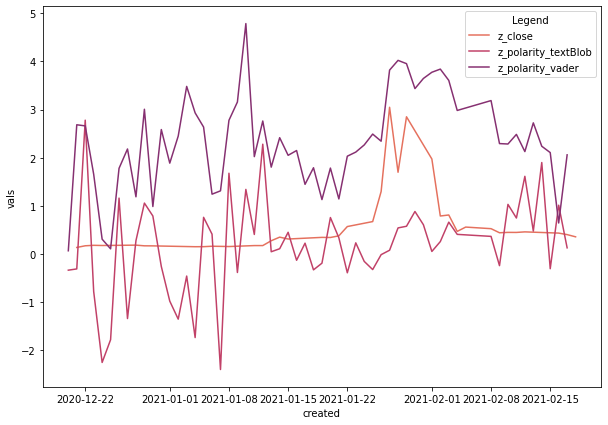

In [11]:
fig, ax = plt.subplots(figsize=(10,7))
mS = merged.loc[:,["created","z_close","z_polarity_textBlob", "z_polarity_vader"]].melt('created', var_name='Legend',  value_name='vals')
sns.lineplot(ax=ax, data=mS, x="created", y="vals", hue='Legend', palette="flare")

We observe a more similar pattern between stock price and sentiment when we use Vader rather than textBlob, however out goal is to discover wether there is a pattern, not to assume there is one. Therefore, as we refine out sentiment analysis methods, we will be able to better assess the existence of this pattern. 

## Word Embeddings

The textBlob and Vader "Bag-of-Words" approach base the sentence sentiment solely on a superposition of the polarity of each individual word, without taking into account what words can mean in context. Therefore we turn to Word Wmbeddings to improve our analysis and attempt to obtain a more fine-grained masure of sentiment.

Hence, we are going to use HansingVectorizer to map the each word in a word vector space, where similar words are close to eachother and dissimilar ones are not. We chose HashingVectorizer because of the memory efficiency. Then we use the Sentiment140 Dataset created by Alec Go, Richa Bhayani, and Lei Huang to train our Support Vector Classifier. The dataser consists of 1.6M tweets about various topics including Obama, Kindle, Windows 10... each with reliable sentiment labels. Once we trained the SVC, we obtian predictions on the sentiment of our Reddit posts. 

### Preprocessing of Sentiment140 Dataset

Here is the code for how we preprocessed the training and testing sets. This takes a while, hence when running this notebook we advise skipping to the cell where we upload the already-preprocessed files below. 

In [ ]:
nltk.download('averaged_perceptron_tagger')

In [ ]:
#training data preproc
rdf = pd.read_csv('reduced1600000KTrainingData.csv')
rdf = rdf.loc[:, ~rdf.columns.str.contains('^Unnamed')]
rdf.columns = ["polarity", "ptitle"]
rdf["ptitle"] = rdf["ptitle"].str.lower().str.replace(r'([^a-zA-Z\s])|(^https?:\/\/.*[\r\n]*)', '') 
rdf["ptitle"] = rdf["ptitle"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
rdf["ptitle"] = rdf["ptitle"].apply(lambda x: tagandlemma(x))
rdf.to_csv("preprocessed_training_final.csv")

#testing data preproc
test = pd.read_csv('reducedTestingData.csv')
test = test[["polarity", "text"]]
test.columns = ["polarity", "ptitle"]
test["ptitle"] = test["ptitle"].str.lower().str.replace(r'([^a-zA-Z\s])|(^https?:\/\/.*[\r\n]*)', '') 
test["ptitle"] = test["ptitle"].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
test["ptitle"] = test["ptitle"].apply(lambda x: tagandlemma(x))
test.to_csv("preprocessed_test.csv")

Here we read the already preprocessed files. Furthermore, since the dataset is organised with all the negative posts at the beginning an the positive at the end, we randomise the rows in order to have randomised appearance of positive and negative comments, in order to avoid bias when triaining the model. 

In [12]:
#training
rdf = pd.read_csv('preprocessed_training_final.csv')
rdf = rdf.loc[:, ~rdf.columns.str.contains('^Unnamed')]
rdf.columns = ["polarity", "ptitle"]

#randomise rows
rdf = rdf.sample(frac=1).reset_index(drop=True)

rdf.head()

,polarity,ptitle
0,0,donniewahlberg plz give away ticket dallas sho...
1,4,hazeljoy bit piece still poorly bore youre wel...
2,0,go mampds en im sun burnt
3,4,rhyiza ooo good ive think buying
4,4,babygirlparis fantastic time paradise drink ma...


In [13]:
#test
test = pd.read_csv('preprocessed_test_final.csv')
test = test.loc[:, ~test.columns.str.contains('^Unnamed')]
test.head()

,polarity,title,ptitle
0,4,@stellargirl I loooooooovvvvvveee my Kindle2. ...,stellargirl loooooooovvvvvveee kindle dx cool ...
1,4,Reading my kindle2... Love it... Lee childs i...,reading kindle love lee child good read
2,4,"Ok, first assesment of the #kindle2 ...it fuck...",ok first assesment kindle fuck rock
3,4,@kenburbary You'll love your Kindle2. I've had...,kenburbary love kindle mine month never look b...
4,4,@mikefish Fair enough. But i have the Kindle2...,mikefish fair enough kindle think perfect


In [14]:
#splitting features and labels
train = rdf.dropna(axis=0)
train_x = train["ptitle"] 
train_y = train["polarity"]   
train_x.head()

0    donniewahlberg plz give away ticket dallas sho...
1    hazeljoy bit piece still poorly bore youre wel...
2                            go mampds en im sun burnt
3                     rhyiza ooo good ive think buying
4    babygirlparis fantastic time paradise drink ma...
Name: ptitle, dtype: object

### The Model

Given the large amount of data, we train in batches to avoid running out of RAM. 

In [89]:
from sklearn.linear_model import SGDClassifier
from sklearn.feature_extraction.text import HashingVectorizer #,TfidfTransformer
#from sklearn.pipeline import make_pipeline
import numpy as np

vectorizer = HashingVectorizer()
#tfTran = TfidfTransformer()
#sklearn.feature_extraction.text.TfidfTransformer¶

clf = SGDClassifier(loss="modified_huber") 

batch_size = 5000
start = 0
epochs = int(len(train_x.index)/batch_size)

for i in range(epochs): 
  train_x_batch = train_x[start:(start+batch_size)]
  train_y_batch = train_y[start:(start+batch_size)]
  
  vectors_x = vectorizer.fit_transform(train_x_batch)
  clf.partial_fit(vectors_x, train_y_batch, classes=np.unique(train_y_batch))
  start = start+batch_size

Now that the SDG is trained, we test the model with the testing dataset provided by Sentiment140.

In [90]:
test_pn = test.loc[test["polarity"]!=2].reset_index(drop=True) #remove neutral tweets since we had none in our training set
predict = pd.DataFrame(test_pn.loc[:,["polarity", "ptitle"]])

test_x = test_pn.loc[:,"ptitle"]
test_y = test_pn.loc[:,"polarity"]

test_vectors_x = vectorizer.fit_transform(test_x.values.astype(str))
predict.loc[:,"pred"] = clf.predict(test_vectors_x)

In [91]:
#checking how many predictions were correct #DELETE, you can do with functions below
count = 0
for i in range(len(predict.index)):
  if predict.loc[i,"polarity"]==predict.loc[i,"pred"]: 
    count=count+1
right_pred = count/len(predict.index)
right_pred

0.8022284122562674

We obtain an accuracy of around 79%, which we consider good enough to proceed and predict the sentiment of our /wallstreetbets submission titles. 

In [92]:
from sklearn.metrics import accuracy_score, recall_score, precision_score, confusion_matrix
y_pred = predict.loc[:,"pred"]
y_true = test_pn.loc[:,"polarity"]

accuracy_score(y_true, y_pred)

0.8022284122562674

In [93]:
recall_score(y_true, y_pred, average=None)

array([0.74011299, 0.86263736])

In [94]:
precision_score(y_true, y_pred, average=None)

array([0.83974359, 0.77339901])

In [95]:
confusion_matrix(y_true, y_pred)

array([[131,  46],
       [ 25, 157]])

### Prediction of WSB Titles

In [65]:
test_gme = sent_df.loc[:,"ptitle"]

test_vectors_x = vectorizer.fit_transform(test_gme.values.astype(str))
sent_df.loc[:,"polarity_WEM"] = clf.predict(test_vectors_x)

In [66]:
sent_df.head()

,created,author,title,ptitle,polarity_textBlob,polarity_vader,polarity_WEM
0,2020-12-29,WallStWarlock,GME sign from the QUAZAR.,gme sign quazar,0.0,0.0000,4
1,2020-12-29,Cali_Godbod,5th trade: GME Gang rise up,th trade gme gang rise,0.0,0.0000,4
2,2020-12-29,Blitz100000,How much to invest in GME and PLTR,much invest gme pltr,0.2,0.0000,4
3,2020-12-29,kunjinn,"Yesterday I was celebrating, today I am in the...",yesterday celebrate today gutter margin use gm...,0.0,0.5719,4
4,2020-12-29,Effect_Wild,"GME DD, look at all the out of stock stickers ...",gme dd look stock sticker,0.0,0.0000,4


In [67]:
#change to specific polarity
def convert_into_range(sent):
  if sent==4: 
    return 1
  else:
    return -1

In [68]:
sent_df.loc[:,"polarity_WEM"] = sent_df.loc[:,"polarity_WEM"].apply(convert_into_range)
sent_df.loc[:,"polarity_WEM"]


0        1
1        1
2        1
3        1
4        1
        ..
76347   -1
76348    1
76349    1
76350    1
76351    1
Name: polarity_WEM, Length: 76352, dtype: int64

In [69]:
daily_sent_df_WEM = sent_df.loc[:,("created", "polarity_WEM")].groupby(["created"], as_index=False).sum()
daily_sent_df_WEM.loc[:,"z_polarity_WEM"] = daily_sent_df_WEM.loc[:,"polarity_WEM"]/daily_sent_df_WEM.loc[:,"polarity_WEM"].std(axis=0)
daily_sent_df_WEM.loc[:,"created"] = pd.to_datetime(daily_sent_df_WEM.loc[:,"created"])
daily_sent_df_WEM

#merge for plotting
merged = merged.merge(daily_sent_df_WEM.loc[:,["created","z_polarity_WEM", "polarity_WEM"]], how='outer')

<AxesSubplot:xlabel='created', ylabel='vals'>

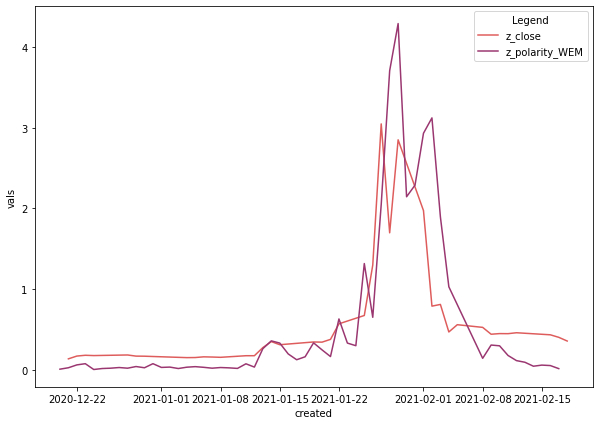

In [70]:
#plotting
fig, ax = plt.subplots(figsize=(10,7))
mS = merged.loc[:,["created","z_close","z_polarity_WEM"]].melt('created', var_name='Legend',  value_name='vals')
sns.lineplot(ax=ax, data=mS, x="created", y="vals", hue='Legend', palette="flare")

<AxesSubplot:xlabel='created', ylabel='vals'>

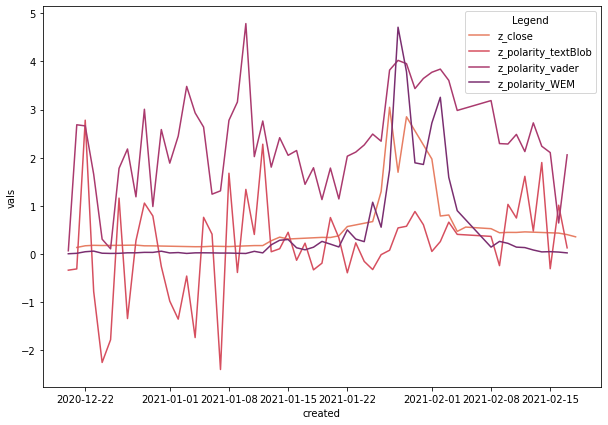

In [25]:
#plot them all together 
fig, ax = plt.subplots(figsize=(10,7))
mS = merged.loc[:,["created","z_close","z_polarity_textBlob", "z_polarity_vader","z_polarity_WEM"]].melt('created', var_name='Legend',  value_name='vals')
sns.lineplot(ax=ax, data=mS, x="created", y="vals", hue='Legend', palette="flare")

# Evaluation & Conclusions 

- Compare Timeline + Stock price + Plots of all Sentiments
- Dicusss and evaluate 
- Streanghts and Weaknessess of appraoch
- Avenues for future improvements 
- Concluding Remarks

#commento sul lungo termine